# 상품명을 보고 카테고리를 분류하는 모델
상품명이 들어가는 자리에 타 채널 Category를 넣으면 Category를 이용해 Category를 분류하는 모델로 사용가능. 
사용한 Bert 모델은 LMkor이라는 한국어 Bert로서 제작자에게 MOU작성시 상업적으로 사용가능 함. 대표적인 한국어 Bert인 klue Bert보다 좋은 성능을 보임 커머스 리뷰 1억개의 데이터가 들어가므로서 이커머스 시장에 더 적합한 Pretrained 모델인 것 같음.



In [2]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 5.7 MB/s 
     |████████████████████████████████| 596 kB 49.1 MB/s 
     |████████████████████████████████| 67 kB 5.0 MB/s 
     |████████████████████████████████| 6.8 MB 49.4 MB/s 
     |████████████████████████████████| 895 kB 58.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
import transformers
transformers.__version__

'4.16.2'

In [4]:
import pandas as pd
import numpy as np
import urllib.request
import os
from tqdm import tqdm
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
%matplotlib inline
import matplotlib.pyplot as plt
import re
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# 데이터 전처리
preprocessing 함수가 전처리 로직인데, 전처리 로직을 안해주는 것이 결과가 좋은 경우가 많음. 전처리에 대한 파라미터 수정을 하면 좋은 결과를 낼 수 도 있을꺼 같음.

In [6]:
def data_delete(train_data):
    train_data = train_data[~train_data['middle_classification'].str.contains("가구/인테리어 장갑", na=False, case=False)]
    train_data = train_data[~train_data['middle_classification'].str.contains("생활/건강 김치", na=False, case=False)]
    train_data = train_data[~train_data['middle_classification'].str.contains("생활/건강 지갑", na=False, case=False)]
    train_data = train_data[~train_data['middle_classification'].str.contains("생활/건강 모자", na=False, case=False)]
    train_data = train_data[~train_data['middle_classification'].str.contains("생활/건강 분유", na=False, case=False)]
    train_data = train_data[~train_data['middle_classification'].str.contains("생활/건강 음료", na=False, case=False)]
    train_data = train_data[~train_data['middle_classification'].str.contains("생활/건강 카시트", na=False, case=False)]
    train_data = train_data[~train_data['middle_classification'].str.contains("생활/건강 낚시", na=False, case=False)]
    train_data = train_data[~train_data['middle_classification'].str.contains("생활/건강 양말", na=False, case=False)]
    train_data = train_data[~train_data['middle_classification'].str.contains("생활/건강 향수", na=False, case=False)]
    train_data = train_data[~train_data['middle_classification'].str.contains("생활/건강 유모차", na=False, case=False)]
    train_data = train_data[~train_data['middle_classification'].str.contains("생활/건강 외출용품", na=False, case=False)]
    train_data = train_data[~train_data['middle_classification'].str.contains("디지털/가전 태블릿PC", na=False, case=False)]
    train_data = train_data[~train_data['middle_classification'].str.contains("생활/건강 벨트", na=False, case=False)]
    train_data = train_data[~train_data['middle_classification'].str.contains("출산/육아 지갑", na=False, case=False)]
    train_data = train_data[~train_data['middle_classification'].str.contains("생활/건강 기저귀", na=False, case=False)]
    train_data = train_data[~train_data['middle_classification'].str.contains("디지털/가전 태블릿PC액세서리", na=False, case=False)]
    train_data = train_data[~train_data['middle_classification'].str.contains("스포츠/레저 모자", na=False, case=False)]
    train_data = train_data[~train_data['middle_classification'].str.contains("출산/육아 모자", na=False, case=False)]
    train_data = train_data[~train_data['middle_classification'].str.contains("생활/건강 솜류", na=False, case=False)]
    train_data = train_data[~train_data['middle_classification'].str.contains("생활/건강 장갑", na=False, case=False)]
    train_data = train_data[~train_data['middle_classification'].str.contains("디지털/가전 PC액세서리", na=False, case=False)]
    train_data = train_data[~train_data['middle_classification'].str.contains("스포츠/레저 벨트", na=False, case=False)]
    train_data = train_data[~train_data['middle_classification'].str.contains("출산/육아 헤어액세서리", na=False, case=False)]
    train_data = train_data[~train_data['middle_classification'].str.contains("출산/육아 네일케어", na=False, case=False)]
    train_data = train_data[~train_data['middle_classification'].str.contains("생활/건강 인형", na=False, case=False)]
    train_data = train_data[~train_data['middle_classification'].str.contains("생활/건강 안전용품", na=False, case=False)]
    return train_data

In [7]:
def data_change(train_data):
    train_data.loc[train_data['middle_classification'] == '가구/인테리어 시계', 'middle_classification'] = '가구/인테리어 인테리어소품'
    train_data.loc[train_data['middle_classification'] == '가구/인테리어 카페트/러그', 'middle_classification'] = '가구/인테리어 인테리어소품'
    train_data.loc[train_data['middle_classification'] == '생활/건강 관상어용품', 'middle_classification'] = '생활/건강 반려동물'
    train_data.loc[train_data['middle_classification'] == '생활/건강 기저귀', 'middle_classification'] = '생활/건강 생활용품'
    train_data.loc[train_data['middle_classification'] == '생활/건강 당뇨관리용품', 'middle_classification'] = '생활/건강 의료용품'
    train_data.loc[train_data['middle_classification'] == '생활/건강 발건강용품', 'middle_classification'] = '생활/건강 건강관리용품'
    train_data.loc[train_data['middle_classification'] == '생활/건강 블루레이', 'middle_classification'] = '생활/건강 DVD'
    train_data.loc[train_data['middle_classification'] == '생활/건강 솜류', 'middle_classification'] = '생활/건강 의료용품'
    train_data.loc[train_data['middle_classification'] == '생활/건강 장갑', 'middle_classification'] = '생활/건강 생활용품'
    train_data.loc[train_data['middle_classification'] == '생활/건강 재활운동용품', 'middle_classification'] = '생활/건강 의료용품'
    train_data.loc[train_data['middle_classification'] == '생활/건강 휴대폰', 'middle_classification'] = '디지털/가전 액세서리'
    train_data.loc[train_data['middle_classification'] == '스포츠/레저 모자', 'middle_classification'] = '스포츠/레저 기타스포츠용품'
    train_data.loc[train_data['middle_classification'] == '스포츠/레저 댄스', 'middle_classification'] = '스포츠/레저 기타스포츠용품'
    train_data.loc[train_data['middle_classification'] == '스포츠/레저 검도', 'middle_classification'] = '스포츠/레저 기타스포츠용품'
    train_data.loc[train_data['middle_classification'] == '스포츠/레저 무술용품', 'middle_classification'] = '스포츠/레저 기타스포츠용품'
    train_data.loc[train_data['middle_classification'] == '스포츠/레저 수련용품', 'middle_classification'] = '스포츠/레저 기타스포츠용품'
    train_data.loc[train_data['middle_classification'] == '스포츠/레저 스킨스쿠버', 'middle_classification'] = '스포츠/레저 기타스포츠용품'
    train_data.loc[train_data['middle_classification'] == '스포츠/레저 보호용품', 'middle_classification'] = '스포츠/레저 기타스포츠용품'
    train_data.loc[train_data['middle_classification'] == '스포츠/레저 장갑', 'middle_classification'] = '스포츠/레저 기타스포츠용품'
    train_data.loc[train_data['middle_classification'] == '스포츠/레저 양말', 'middle_classification'] = '스포츠/레저 기타스포츠용품'
    train_data.loc[train_data['middle_classification'] == '출산/육아 양말', 'middle_classification'] = '출산/육아 유아동잡화'
    train_data.loc[train_data['middle_classification'] == '출산/육아 장갑', 'middle_classification'] = '출산/육아 유아동잡화'
    train_data.loc[train_data['middle_classification'] == '출산/육아 벨트', 'middle_classification'] = '출산/육아 유아동잡화'
    train_data.loc[train_data['middle_classification'] == '출산/육아 모자', 'middle_classification'] = '출산/육아 유아동잡화'
    train_data.loc[train_data['middle_classification'] == '출산/육아 지갑', 'middle_classification'] = '출산/육아 유아동잡화'
    train_data.loc[train_data['middle_classification'] == '출산/육아 소독/살균용품', 'middle_classification'] = '출산/육아 위생/건강용품'
    train_data.loc[train_data['middle_classification'] == '출산/육아 신생아의류', 'middle_classification'] = '출산/육아 유아동의류'
    train_data.loc[train_data['middle_classification'] == '출산/육아 출산/돌기념품', 'middle_classification'] = '출산/육아 유아동잡화'
    train_data.loc[train_data['middle_classification'] == '패션잡화 순금', 'middle_classification'] = '패션잡화 주얼리'
    return train_data

In [8]:
import re
import json
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup

num = [1,2,3,4,5,6,7,8,9,10]
stopword = ["혼합색상", "그린", "블루", "핑크", "레드", "블랙", "화이트", "그레이","옐로우", "크림", "차콜","노랑","실버","빨강","오렌지","베이지","퍼플","보라","옐로우","옐로우", "\n"] # [ str(number)+"종" for number in num ] + 
stopword

def preprocessing (data, remove_stopwords = True ): 
    # 불용어 제거는 옵션으로 선택 가능하다.
    
    # 1. HTML 태그 제거
    pre_data = BeautifulSoup(data, "html5lib").get_text()	

    # 2. 영어가 아닌 특수문자들을 공백(" ")으로 바꾸기
    pre_data = re.sub("[^a-zA-Zㄱ-힣]", " ", pre_data)

    # 3. 대문자들을 소문자로 바꾸고 공백단위로 텍스트들 나눠서 리스트로 만든다.
    words = pre_data.lower().split()
    if remove_stopwords: 
        # 4. 불용어들을 제거
    
        stops = stopword
        # 불용어가 아닌 단어들로 이루어진 새로운 리스트 생성
        word = [w for w in words if not w in stops]
        # word = []
        # stops = [ "개", "박스", "box", "p", "세트", "색상"]
        # # 불용어가 아닌 단어들로 이루어진 새로운 리스트 생성
        # for w in words:
        #     word.append(w)
        #     for s in stops:
        #         if (s in w):
        #             word.remove(w)
        #             break
        words = word
        

        # 5. 단어 리스트를 공백을 넣어서 하나의 글로 합친다.	
        clean_data = ' '.join(words)

    else: # 불용어 제거하지 않을 때
        clean_data = ' '.join(words)
    if (len(clean_data) <= 5):
        clean_data = data

    return clean_data


# 데이터 로드
학습 데이터와 평가 데이터를 load하는 부분 학습데이터와 평가데이터에 모델에 넣을 수 있게 label을 달아주는 작업도 함 train이 많으면 성능이 좋아 train 두개 모두 병합

In [31]:
train_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/colab_data/model/N2C_train_v2.csv')
train_data1 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/colab_data/model/N2C_train_v1.csv')
train_data = pd.concat([train_data, train_data1])
test_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/colab_data/model/N2C_test_v2.csv')
test_data

,Unnamed: 0,name,middle_classification
0,9706,"사노산 베이비 바스 앤 샴푸, 500ml, 1개",출산/육아 스킨/바디용품
1,68683,살균기 소독기 세탁기 완전 자동 아기 젖병,출산/육아 위생/건강용품
2,64663,마닛또 mm스텐용접티sch20ks 65x40 ms0119 무료배송,디지털/가전 계절가전
3,17093,"삼광 생와사비 999, 80g, 3개",식품 가공식품
4,66468,트리오텍 이큐 복사용지 v 27500매,생활/건강 문구/사무용품
...,...,...,...
49995,4148,여성 칸막이수납 별모양 손가방 워크샵 야외운동,출산/육아 수영복/용품
49996,63322,osmo 오스모 포릭스오일 3032 3062 3011,생활/건강 공구
49997,100256,"에이치엘사이언스 미녀들의 시크릿 빨강석류 콜라겐 15p, 12개, 420g",식품 건강식품
49998,39147,sk zic 지크 x7 5w30 4l,생활/건강 자동차용품


In [32]:
train_data = data_change(train_data)
test_data = data_change(test_data)
train_data = data_delete(train_data)
test_data = data_delete(test_data)

In [33]:
label_list = list(train_data.middle_classification.unique())
data_label = list(train_data["middle_classification"])
mapping_data = []
for i in range(len(label_list)):
    mapping_data.append([i,label_list[i]])
print(mapping_data)
for x in range(len(data_label)):
    for y in mapping_data:
        if (data_label[x] == y[1]):
            data_label[x] = y[0]
train_data["label"] = data_label



[[0, '패션잡화 남성가방'], [1, '패션잡화 남성신발'], [2, '디지털/가전 주방가전'], [3, '스포츠/레저 헬스'], [4, '출산/육아 위생/건강용품'], [5, '생활/건강 주방용품'], [6, '디지털/가전 이미용가전'], [7, '식품 수산'], [8, '출산/육아 목욕용품'], [9, '출산/육아 수유용품'], [10, '스포츠/레저 야구'], [11, '생활/건강 화방용품'], [12, '생활/건강 정원/원예용품'], [13, '패션잡화 시계'], [14, '디지털/가전 음향가전'], [15, '생활/건강 건강관리용품'], [16, '출산/육아 외출용품'], [17, '스포츠/레저 기타스포츠용품'], [18, '스포츠/레저 스키/보드'], [19, '디지털/가전 카메라/캠코더용품'], [20, '생활/건강 악기'], [21, '생활/건강 문구/사무용품'], [22, '생활/건강 냉온/찜질용품'], [23, '출산/육아 이유식'], [24, '출산/육아 기저귀'], [25, '도서 서적'], [26, '패션의류 남성언더웨어/잠옷'], [27, '출산/육아 유아동의류'], [28, '생활/건강 안마용품'], [29, '출산/육아 완구/매트'], [30, '가구/인테리어 주방가구'], [31, '생활/건강 자동차용품'], [32, '가구/인테리어 아동/주니어가구'], [33, '생활/건강 의료용품'], [34, '패션잡화 지갑'], [35, '패션잡화 여성신발'], [36, '디지털/가전 모니터'], [37, '스포츠/레저 축구'], [38, '패션잡화 주얼리'], [39, '패션잡화 선글라스/안경테'], [40, '화장품/미용 베이스메이크업'], [41, '디지털/가전 휴대폰액세서리'], [42, '스포츠/레저 골프'], [43, '가구/인테리어 커튼/블라인드'], [44, '식품 음료'], [45, '패션의류 여성의류'], [46, '패션의류 여성언더웨어/잠옷'], [47, '스포츠/레저 테니스'], [48, '패션잡화 여성가방'], 

In [34]:
label_list = list(test_data.middle_classification.unique())
data_label = list(test_data["middle_classification"])
print(mapping_data)
for x in range(len(data_label)):
    for y in mapping_data:
        if (data_label[x] == y[1]):
            data_label[x] = y[0]
test_data["label"] = data_label

[[0, '패션잡화 남성가방'], [1, '패션잡화 남성신발'], [2, '디지털/가전 주방가전'], [3, '스포츠/레저 헬스'], [4, '출산/육아 위생/건강용품'], [5, '생활/건강 주방용품'], [6, '디지털/가전 이미용가전'], [7, '식품 수산'], [8, '출산/육아 목욕용품'], [9, '출산/육아 수유용품'], [10, '스포츠/레저 야구'], [11, '생활/건강 화방용품'], [12, '생활/건강 정원/원예용품'], [13, '패션잡화 시계'], [14, '디지털/가전 음향가전'], [15, '생활/건강 건강관리용품'], [16, '출산/육아 외출용품'], [17, '스포츠/레저 기타스포츠용품'], [18, '스포츠/레저 스키/보드'], [19, '디지털/가전 카메라/캠코더용품'], [20, '생활/건강 악기'], [21, '생활/건강 문구/사무용품'], [22, '생활/건강 냉온/찜질용품'], [23, '출산/육아 이유식'], [24, '출산/육아 기저귀'], [25, '도서 서적'], [26, '패션의류 남성언더웨어/잠옷'], [27, '출산/육아 유아동의류'], [28, '생활/건강 안마용품'], [29, '출산/육아 완구/매트'], [30, '가구/인테리어 주방가구'], [31, '생활/건강 자동차용품'], [32, '가구/인테리어 아동/주니어가구'], [33, '생활/건강 의료용품'], [34, '패션잡화 지갑'], [35, '패션잡화 여성신발'], [36, '디지털/가전 모니터'], [37, '스포츠/레저 축구'], [38, '패션잡화 주얼리'], [39, '패션잡화 선글라스/안경테'], [40, '화장품/미용 베이스메이크업'], [41, '디지털/가전 휴대폰액세서리'], [42, '스포츠/레저 골프'], [43, '가구/인테리어 커튼/블라인드'], [44, '식품 음료'], [45, '패션의류 여성의류'], [46, '패션의류 여성언더웨어/잠옷'], [47, '스포츠/레저 테니스'], [48, '패션잡화 여성가방'], 

# 전처리 할때의 로직
전처리 하지 않는 경우는 아래 셀 실행 전처리 하지않는 경우가 성능이 좋은 경우가 많음

In [13]:
clean_train = []
for review in train_data['name']:
    clean_train.append(preprocessing(review, remove_stopwords = True)) # 불용어 제거 안하는 경우 False

train_data["document"] = clean_train
train_data = train_data[["document", "label"]]

clean_train = []
for review in test_data['name']:
    clean_train.append(preprocessing(review, remove_stopwords = True)) # 불용어 제거 안하는 경우 False

test_data["document"] = clean_train
test_data = test_data[["document", "label"]]
test_data

,document,label
0,사노산 베이비 바스 앤 샴푸 ml 개,57
1,살균기 소독기 세탁기 완전 자동 아기 젖병,4
2,마닛또 mm스텐용접티sch ks x ms 무료배송,108
3,삼광 생와사비 g 개,59
4,트리오텍 이큐 복사용지 v 매,21
...,...,...
49995,여성 칸막이수납 별모양 손가방 워크샵 야외운동,150
49996,osmo 오스모 포릭스오일,61
49997,에이치엘사이언스 미녀들의 시크릿 빨강석류 콜라겐 p 개 g,102
49998,sk zic 지크 x w l,31


# 전처리 안하는 경우

In [35]:
train_data["document"] = train_data["name"]
train_data = train_data[["document", "label"]]

test_data["document"] = test_data["name"]
test_data = test_data[["document", "label"]]
test_data

,document,label
0,"사노산 베이비 바스 앤 샴푸, 500ml, 1개",57
1,살균기 소독기 세탁기 완전 자동 아기 젖병,4
2,마닛또 mm스텐용접티sch20ks 65x40 ms0119 무료배송,108
3,"삼광 생와사비 999, 80g, 3개",59
4,트리오텍 이큐 복사용지 v 27500매,21
...,...,...
49995,여성 칸막이수납 별모양 손가방 워크샵 야외운동,150
49996,osmo 오스모 포릭스오일 3032 3062 3011,61
49997,"에이치엘사이언스 미녀들의 시크릿 빨강석류 콜라겐 15p, 12개, 420g",102
49998,sk zic 지크 x7 5w30 4l,31


In [36]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [37]:
test_data = test_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(test_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


# data check

In [38]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 451377


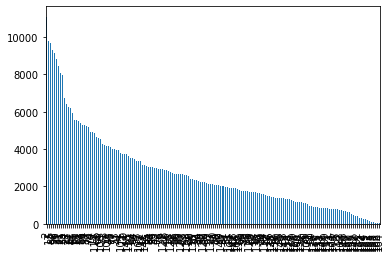

In [39]:
train_data['label'].value_counts().plot(kind = 'bar') # 데이터 분포가 균등하지 못함. 그래도 pretrained model이라 어느정도 괜찮음 

# Bert token화와 convert train, test data

In [40]:
from transformers import BertTokenizerFast, BertModel
# tokenizer = BertTokenizer.from_pretrained('klue/bert-base')
tokenizer = BertTokenizerFast.from_pretrained('kykim/bert-kor-base')

In [41]:
max_seq_len = 128
from tensorflow.keras.utils import to_categorical

In [42]:
def convert_examples_to_features(examples, labels, max_seq_len, tokenizer):
    
    input_ids, attention_masks, token_type_ids, data_labels = [], [], [], []
    
    for example, label in tqdm(zip(examples, labels), total=len(examples)):
        input_id = tokenizer.encode(example, max_length=max_seq_len, pad_to_max_length=True)
        padding_count = input_id.count(tokenizer.pad_token_id)
        attention_mask = [1] * (max_seq_len - padding_count) + [0] * padding_count
        token_type_id = [0] * max_seq_len

        assert len(input_id) == max_seq_len, "Error with input length {} vs {}".format(len(input_id), max_seq_len)
        assert len(attention_mask) == max_seq_len, "Error with attention mask length {} vs {}".format(len(attention_mask), max_seq_len)
        assert len(token_type_id) == max_seq_len, "Error with token type length {} vs {}".format(len(token_type_id), max_seq_len)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        label= to_categorical(label, len(mapping_data))
        data_labels.append(label)

    input_ids = np.array(input_ids, dtype=int)
    attention_masks = np.array(attention_masks, dtype=int)
    token_type_ids = np.array(token_type_ids, dtype=int)

    data_labels = np.asarray(data_labels, dtype=np.int32)

    return (input_ids, attention_masks, token_type_ids), data_labels

In [43]:
train_X, train_y = convert_examples_to_features(train_data['document'], train_data['label'], max_seq_len=max_seq_len, tokenizer=tokenizer)

  0%|          | 0/451377 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 451377/451377 [03:30<00:00, 2147.74it/s]


In [44]:
test_X, test_y = convert_examples_to_features(test_data['document'], test_data['label'], max_seq_len=max_seq_len, tokenizer=tokenizer)

  0%|          | 0/49919 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 49919/49919 [00:12<00:00, 3982.20it/s]


In [45]:
# model = TFBertModel.from_pretrained("klue/bert-base", from_pt=True)
model = TFBertModel.from_pretrained("kykim/bert-kor-base", from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.weight', 'bert.embeddings.position_ids', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

In [46]:
max_seq_len = 128

In [47]:
input_ids_layer = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32)
attention_masks_layer = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32)
token_type_ids_layer = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32)

outputs = model([input_ids_layer, attention_masks_layer, token_type_ids_layer])

# Basic Classification Model

In [48]:
class TFBertForSequenceClassification(tf.keras.Model):
    def __init__(self, model_name):
        super(TFBertForSequenceClassification, self).__init__()
        self.bert = TFBertModel.from_pretrained(model_name, from_pt=True)
        self.classifier = tf.keras.layers.Dense(len(mapping_data),
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(0.02),
                                                activation='softmax',
                                                name='classifier')

    def call(self, inputs):
        input_ids, attention_mask, token_type_ids = inputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        cls_token = outputs[1]
        prediction = self.classifier(cls_token)

        return prediction

# Colab TPU 사용시 입력 코드

In [49]:
# TPU 작동을 위한 코드 TPU 작동을 위한 코드
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.119.82.74:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.119.82.74:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


In [50]:
strategy = tf.distribute.experimental.TPUStrategy(resolver)

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [51]:
with strategy.scope():
#   model = TFBertForSequenceClassification("klue/bert-base")
  model = TFBertForSequenceClassification("kykim/bert-kor-base")
  optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
  loss = 'categorical_crossentropy'
  model.compile(optimizer=optimizer, loss=loss, metrics = ['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.weight', 'bert.embeddings.position_ids', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

# 모델 학습
train이 많을 수록 성능이 좋아 validation 작게 설정

In [52]:
from tensorflow.keras.callbacks import EarlyStopping

callback_earlystop = EarlyStopping(
    monitor="val_accuracy", 
    min_delta=0.001,
    patience=2)
model.fit(train_X, train_y, epochs=10, batch_size=32, validation_split=0.05, callbacks=[callback_earlystop])

Epoch 1/10
13401/13401 [==============================] - 1223s 85ms/step - loss: 1.0247 - accuracy: 0.7482 - val_loss: 0.7162 - val_accuracy: 0.8166
Epoch 2/10
13401/13401 [==============================] - 1074s 80ms/step - loss: 0.6142 - accuracy: 0.8382 - val_loss: 0.6164 - val_accuracy: 0.8403
Epoch 3/10
13401/13401 [==============================] - 1075s 80ms/step - loss: 0.4729 - accuracy: 0.8704 - val_loss: 0.5896 - val_accuracy: 0.8504
Epoch 4/10
13401/13401 [==============================] - 1074s 80ms/step - loss: 0.3817 - accuracy: 0.8910 - val_loss: 0.5951 - val_accuracy: 0.8535
Epoch 5/10
13401/13401 [==============================] - 1074s 80ms/step - loss: 0.3177 - accuracy: 0.9066 - val_loss: 0.5992 - val_accuracy: 0.8564
Epoch 6/10
13401/13401 [==============================] - 1074s 80ms/step - loss: 0.2696 - accuracy: 0.9186 - val_loss: 0.6069 - val_accuracy: 0.8579
Epoch 7/10
13401/13401 [==============================] - 1077s 80ms/step - loss: 0.2353 - accuracy:

KeyboardInterrupt: ignored

In [ ]:
model.evaluate(test_X, test_y, batch_size=1024)

10/10 [==============================] - 20s 1s/step - loss: 0.8649 - accuracy: 0.8036


[0.8648595809936523, 0.803555428981781]

# 모델 저장은 TPU사용시 Google Cloud에 저장을 해야함. 저장후 GPU와 동일한 방법으로 사용가능